### Step 1: Importing the Relevant Libraries

In [1026]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import math

import warnings
warnings.filterwarnings('ignore')

### Step 2: Data Inspection

In [1027]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [1028]:
train.shape,test.shape

((30000, 24), (20000, 23))

In [1029]:
#ratio of null values
print(train.columns)
print(test.columns)

Index(['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)',
       'Income Stability', 'Profession', 'Type of Employment', 'Location',
       'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
       'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Has Active Credit Card', 'Property ID',
       'Property Age', 'Property Type', 'Property Location', 'Co-Applicant',
       'Property Price', 'Loan Sanction Amount (USD)'],
      dtype='object')
Index(['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)',
       'Income Stability', 'Profession', 'Type of Employment', 'Location',
       'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
       'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Has Active Credit Card', 'Property ID',
       'Property Age', 'Property Type', 'Property Location', 'Co-Applicant',
       'Property Price'],
      dtype='object')


In [1030]:
#categorical features
categorical = train.select_dtypes(include =[np.object])
print("Categorical Features in Train Set:",categorical.shape[1])

#numerical features
numerical= train.select_dtypes(include =[np.float64,np.int64])
print("Numerical Features in Train Set:",numerical.shape[1])

Categorical Features in Train Set: 11
Numerical Features in Train Set: 13


In [1031]:
#categorical features
categorical_ = test.select_dtypes(include =[np.object])
print("Categorical Features in Test Set:",categorical_.shape[1])

#numerical features
numerical_= test.select_dtypes(include =[np.float64,np.int64])
print("Numerical Features in Test Set:",numerical_.shape[1])

Categorical Features in Test Set: 13
Numerical Features in Test Set: 10


In [1032]:
print(categorical.columns)
print(categorical_.columns)

Index(['Customer ID', 'Name', 'Gender', 'Income Stability', 'Profession',
       'Type of Employment', 'Location', 'Expense Type 1', 'Expense Type 2',
       'Has Active Credit Card', 'Property Location'],
      dtype='object')
Index(['Customer ID', 'Name', 'Gender', 'Income Stability', 'Profession',
       'Type of Employment', 'Location', 'Expense Type 1', 'Expense Type 2',
       'Has Active Credit Card', 'Property Location', 'Co-Applicant',
       'Property Price'],
      dtype='object')


In [1033]:
print(train['Co-Applicant'].value_counts())
print(test['Co-Applicant'].value_counts())

 1      25516
 0       4316
-999      168
Name: Co-Applicant, dtype: int64
1    17004
0     2919
?       77
Name: Co-Applicant, dtype: int64


In [1034]:
train['Co-Applicant'] = train['Co-Applicant'].replace(-999,1)
test['Co-Applicant'] = test['Co-Applicant'].replace(['?','1','0'],[1,1,0])
test['Property Price'] = test['Property Price'].replace('?','-999')
test['Property Price'] = test['Property Price'].apply(pd.to_numeric)

In [1035]:
print(train['Gender'].value_counts(dropna=False))
print(test['Gender'].value_counts(dropna=False))

M      15053
F      14894
NaN       53
Name: Gender, dtype: int64
F      10142
M       9827
NaN       31
Name: Gender, dtype: int64


In [1036]:
train['Gender'] = train['Gender'].fillna('M')
test['Gender'] = test['Gender'].fillna('F')

In [1037]:
print(train['Income Stability'].value_counts(dropna=False))
print(test['Income Stability'].value_counts(dropna=False))

Low     25751
High     2566
NaN      1683
Name: Income Stability, dtype: int64
Low     17501
High     1686
NaN       813
Name: Income Stability, dtype: int64


In [1038]:
train['Income Stability'] = train['Income Stability'].fillna('Low')
test['Income Stability'] = test['Income Stability'].fillna('Low')

In [1039]:
print(train['Profession'].value_counts(dropna=False))
print(test['Profession'].value_counts(dropna=False))

Working                 16926
Commercial associate     7962
Pensioner                2740
State servant            2366
Businessman                 2
Unemployed                  2
Student                     1
Maternity leave             1
Name: Profession, dtype: int64
Working                 11405
Commercial associate     5247
Pensioner                1764
State servant            1577
Student                     4
Unemployed                  2
Maternity leave             1
Name: Profession, dtype: int64


In [1040]:
print(train['Type of Employment'].value_counts(dropna=False))
print(test['Type of Employment'].value_counts(dropna=False))

NaN                      7270
Laborers                 5578
Sales staff              3736
Core staff               3230
Managers                 2495
Drivers                  1606
Accountants              1379
High skill tech staff    1307
Medicine staff            864
Security staff            579
Cooking staff             566
Private service staff     342
Cleaning staff            341
Low-skill Laborers        162
Secretaries               161
Waiters/barmen staff      149
Realty agents              86
IT staff                   77
HR staff                   72
Name: Type of Employment, dtype: int64
NaN                      4689
Laborers                 3743
Sales staff              2433
Core staff               2232
Managers                 1719
Drivers                  1057
Accountants               886
High skill tech staff     881
Medicine staff            598
Cooking staff             405
Security staff            377
Cleaning staff            230
Private service staff     201
L

In [1041]:
print(train[train['Type of Employment'].isna()]['Profession'].value_counts())
print(test[test['Type of Employment'].isna()]['Profession'].value_counts())

Pensioner               2740
Working                 2661
Commercial associate    1438
State servant            427
Unemployed                 2
Student                    1
Maternity leave            1
Name: Profession, dtype: int64
Pensioner               1764
Working                 1763
Commercial associate     904
State servant            256
Unemployed                 2
Name: Profession, dtype: int64


Profession does not seem to be adding value to Type of Employment, hence droping the columns

In [1042]:
train = train.drop(['Profession'],axis=1)
test = test.drop(['Profession'],axis=1)

Ranking Type of Employment based on salary level

In [1043]:
ranks = {'Laborers':1,
        'Sales staff':2,
        'Core staff':3,
        'Managers':5,
        'Drivers':1,
        'Accountants':3,
        'High skill tech staff':5,
        'Medicine staff':4,
        'Security staff':2,
        'Cooking staff':2,
        'Private service staff':3,
        'Cleaning staff':1,
        'Low-skill Laborers':0,
        'Secretaries':3,
        'Waiters/barmen staff':1,
        'Realty agents':3,
        'IT staff':3,
        'HR staff':4}
train['Type of Employment'] = train['Type of Employment'].replace(ranks)
train['Type of Employment'] = train['Type of Employment'].fillna(2)
test['Type of Employment'] = test['Type of Employment'].replace(ranks)
test['Type of Employment'] = test['Type of Employment'].fillna(2)

In [1044]:
print(train['Location'].value_counts(dropna=False))
print(test['Location'].value_counts(dropna=False))

Semi-Urban    21563
Rural          5338
Urban          3099
Name: Location, dtype: int64
Semi-Urban    14463
Rural          3436
Urban          2101
Name: Location, dtype: int64


In [1045]:
print(train['Expense Type 1'].value_counts(dropna=False))
print(test['Expense Type 1'].value_counts(dropna=False))
print(train['Expense Type 2'].value_counts(dropna=False))
print(test['Expense Type 2'].value_counts(dropna=False))

N    19214
Y    10786
Name: Expense Type 1, dtype: int64
N    12816
Y     7184
Name: Expense Type 1, dtype: int64
Y    20180
N     9820
Name: Expense Type 2, dtype: int64
Y    13383
N     6617
Name: Expense Type 2, dtype: int64


In [1046]:
print(train['Has Active Credit Card'].value_counts(dropna=False))
print(test['Has Active Credit Card'].value_counts(dropna=False))

Active         9771
Inactive       9466
Unpossessed    9197
NaN            1566
Name: Has Active Credit Card, dtype: int64
Active         6418
Inactive       6376
Unpossessed    6130
NaN            1076
Name: Has Active Credit Card, dtype: int64


In [1047]:
train['Has Active Credit Card'] = train['Has Active Credit Card'].fillna('Unknown')
test['Has Active Credit Card'] = test['Has Active Credit Card'].fillna('Unknown')

In [1048]:
print(train['Property Location'].value_counts(dropna=False))
print(test['Property Location'].value_counts(dropna=False))

Semi-Urban    10387
Rural         10041
Urban          9216
NaN             356
Name: Property Location, dtype: int64
Semi-Urban    6839
Rural         6768
Urban         6233
NaN            160
Name: Property Location, dtype: int64


In [1049]:
train['Property Location'] = train['Property Location'].fillna('Unknown')
test['Property Location'] = test['Property Location'].fillna('Unknown')

Changing Dependents to catregorical data

In [1050]:
print(train['Dependents'].value_counts(dropna=False))
print(test['Dependents'].value_counts(dropna=False))

2.0     13108
3.0      5719
1.0      5544
4.0      2704
NaN      2493
5.0       372
6.0        50
7.0         7
8.0         1
14.0        1
10.0        1
Name: Dependents, dtype: int64
2.0     8951
3.0     3874
1.0     3843
4.0     1915
NaN     1142
5.0      245
6.0       21
8.0        4
7.0        3
10.0       1
13.0       1
Name: Dependents, dtype: int64


In [1051]:
train['Dependents'] = train['Dependents'].fillna(2)
test['Dependents'] = test['Dependents'].fillna(2)
train.loc[(train['Dependents']>4),'Dependents'] = 5
test.loc[(test['Dependents']>4),'Dependents'] = 5
# train.loc[(train['Dependents']>3),'Dependents'] = 0
# test.loc[(test['Dependents']>3),'Dependents'] = 0

__Numberical__

In [1052]:
print(numerical.columns)
print(numerical_.columns)

Index(['Age', 'Income (USD)', 'Loan Amount Request (USD)',
       'Current Loan Expenses (USD)', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Property ID', 'Property Age', 'Property Type',
       'Co-Applicant', 'Property Price', 'Loan Sanction Amount (USD)'],
      dtype='object')
Index(['Age', 'Income (USD)', 'Loan Amount Request (USD)',
       'Current Loan Expenses (USD)', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Property ID', 'Property Age', 'Property Type'],
      dtype='object')


count    29828.000000
mean       400.936876
std        242.545375
min       -999.000000
25%        247.667500
50%        375.205000
75%        521.292500
max       3840.880000
Name: Current Loan Expenses (USD), dtype: float64

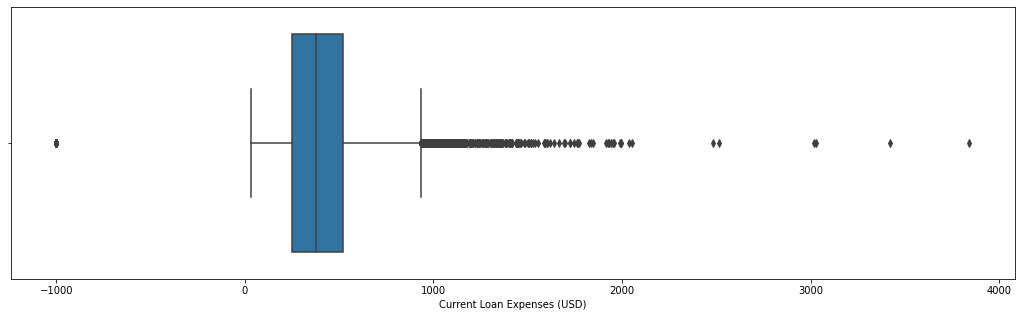

In [1053]:
st = 'Current Loan Expenses (USD)'
plt.figure(figsize=(18,5))
sns.boxplot(st,data=train)
train[st].describe()

count    19917.000000
mean       408.462359
std        215.846532
min         41.370000
25%        250.890000
50%        374.000000
75%        519.570000
max       3305.970000
Name: Current Loan Expenses (USD), dtype: float64

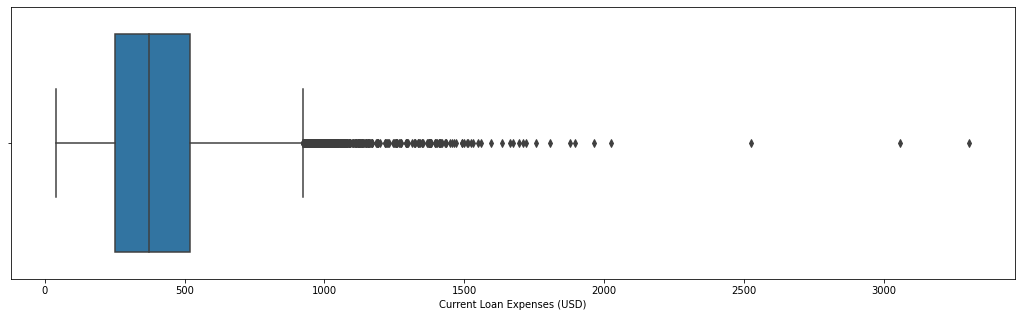

In [1054]:
plt.figure(figsize=(18,5))
sns.boxplot(st,data=test)
test[st].describe()

In [1055]:
print(train[st].value_counts(dropna=False))
print(test[st].value_counts(dropna=False))

-999.00    177
 NaN       172
 333.79      6
 366.37      6
 323.12      5
          ... 
 159.11      1
 733.01      1
 429.59      1
 548.57      1
 170.46      1
Name: Current Loan Expenses (USD), Length: 24042, dtype: int64
NaN       83
417.47     4
297.01     4
243.54     4
273.20     4
          ..
475.53     1
285.04     1
239.84     1
543.43     1
679.33     1
Name: Current Loan Expenses (USD), Length: 17248, dtype: int64


In [1056]:
print(train['Current Loan Expenses (USD)'].value_counts(dropna=False))
print(test['Current Loan Expenses (USD)'].value_counts(dropna=False))

-999.00    177
 NaN       172
 333.79      6
 366.37      6
 323.12      5
          ... 
 159.11      1
 733.01      1
 429.59      1
 548.57      1
 170.46      1
Name: Current Loan Expenses (USD), Length: 24042, dtype: int64
NaN       83
417.47     4
297.01     4
243.54     4
273.20     4
          ..
475.53     1
285.04     1
239.84     1
543.43     1
679.33     1
Name: Current Loan Expenses (USD), Length: 17248, dtype: int64


In [1057]:
train['Current Loan Expenses (USD)'] = train['Current Loan Expenses (USD)'].replace(-999,np.nan)
train['Current Loan Expenses (USD)'] = 100 * train['Current Loan Expenses (USD)']
test['Current Loan Expenses (USD)'] = 100 * test['Current Loan Expenses (USD)']

train['Current Loan Expenses (USD)'] = train['Current Loan Expenses (USD)'].fillna(round(train['Current Loan Expenses (USD)'].mean(),0))
test['Current Loan Expenses (USD)'] = test['Current Loan Expenses (USD)'].fillna(round(test['Current Loan Expenses (USD)'].mean(),0))
train['Credit Score'] = train['Credit Score'].fillna(train['Credit Score'].mean())
test['Credit Score'] = test['Credit Score'].fillna(test['Credit Score'].mean())

There are some outliers in Property Age and Property Price

In [1058]:
train['Property Age'] = train['Property Age']/(365)
test['Property Age'] = test['Property Age']/(365)
print(train['Property Age'].value_counts(dropna=False))
print(test['Property Age'].value_counts(dropna=False))

NaN          4850
4.406658        4
6.618356        4
5.042959        3
5.793205        3
             ... 
11.501562       1
4.453041        1
5.551890        1
5.164027        1
4.682027        1
Name: Property Age, Length: 24180, dtype: int64
NaN         892
5.606932      3
5.542274      3
5.268822      3
3.565123      3
           ... 
6.469616      1
8.996466      1
3.565863      1
1.880630      1
6.108301      1
Name: Property Age, Length: 18561, dtype: int64


In [1059]:
print(train[train['Property Price']<train['Loan Amount Request (USD)']]['Property Price'].value_counts(dropna=False))
print(test[test['Property Price']<test['Loan Amount Request (USD)']]['Property Price'].value_counts(dropna=False))

-999.0    352
Name: Property Price, dtype: int64
-999.0    168
Name: Property Price, dtype: int64


In [1060]:
df = train[train['Property Age'].isna()][['Property Age']]
df2 = train[~train['Property Age'].isna()][['Property Age','Property Location','Property Type']]
for i in df.index:
    train.loc[i,'Property Age'] = df2[(df2['Property Location']==train.at[i,'Property Location']) & (df2['Property Type'] == train.at[i,'Property Type'])]['Property Age'].mean()

In [1061]:
df = test[test['Property Age'].isna()][['Property Age']]
df2 = test[~test['Property Age'].isna()][['Property Age','Property Location','Property Type']]
for i in df.index:
    test.loc[i,'Property Age'] = df2[(df2['Property Location']==test.at[i,'Property Location']) & (df2['Property Type'] == test.at[i,'Property Type'])]['Property Age'].mean()

In [1062]:
train = train[train['Property Age']<90]
test = test[test['Property Age']<90]
while train['Property Age'].min()>test['Property Age'].min():
    test.loc[test['Property Age']==test['Property Age'].min(),'Property Age'] = train['Property Age'].min()

In [1063]:
df = train[train['Property Price']<0][['Property Price']]
df2 = train[train['Property Price']>0][['Property Price','Property Location','Property Type']]
for i in df.index:
    train.loc[i,'Property Price'] = df2[(df2['Property Location']==train.at[i,'Property Location']) & (df2['Property Type'] == train.at[i,'Property Type'])]['Property Price'].mean()

In [1064]:
df = test[test['Property Price']<0][['Property Price']]
df2 = test[test['Property Price']>0][['Property Price','Property Location','Property Type']]
for i in df.index:
    test.loc[i,'Property Price'] = df2[(df2['Property Location']==test.at[i,'Property Location']) & (df2['Property Type'] == test.at[i,'Property Type'])]['Property Price'].mean()

In [1065]:
print(train['Property ID'].value_counts(dropna=False))
print(test['Property ID'].value_counts(dropna=False))

839    51
944    46
102    46
614    45
870    45
       ..
807    18
346    17
345    17
299    16
629    15
Name: Property ID, Length: 999, dtype: int64
68     36
276    35
168    34
764    34
613    33
       ..
313    10
866     9
8       9
195     9
513     9
Name: Property ID, Length: 999, dtype: int64


In [1066]:
train = train.drop(['Property ID'],axis=1)
test = test.drop(['Property ID'],axis=1)

Income (USD)

In [1067]:
df = train[train['Income (USD)'].isna()][['Income (USD)']]
df2 = train[~train['Income (USD)'].isna()][['Income (USD)','Type of Employment']]
for i in df.index:
    train.loc[i,'Income (USD)'] = df2[(df2['Type of Employment'] == train.at[i,'Type of Employment'])]['Income (USD)'].mean()

In [1068]:
df = test[test['Income (USD)'].isna()][['Income (USD)']]
df2 = test[~test['Income (USD)'].isna()][['Income (USD)','Type of Employment']]
for i in df.index:
    test.loc[i,'Income (USD)'] = df2[(df2['Type of Employment'] == test.at[i,'Type of Employment'])]['Income (USD)'].mean()

In [1069]:
train = train[train['Income (USD)']<40000]
test = test[test['Income (USD)']<40000]
while train['Income (USD)'].min()>test['Income (USD)'].min():
    test.loc[test['Income (USD)']==test['Income (USD)'].min(),'Income (USD)'] = train['Income (USD)'].min()

In [1070]:
train.isnull().sum()

Customer ID                      0
Name                             0
Gender                           0
Age                              0
Income (USD)                     0
Income Stability                 0
Type of Employment               0
Location                         0
Loan Amount Request (USD)        0
Current Loan Expenses (USD)      0
Expense Type 1                   0
Expense Type 2                   0
Dependents                       0
Credit Score                     0
No. of Defaults                  0
Has Active Credit Card           0
Property Age                     0
Property Type                    0
Property Location                0
Co-Applicant                     0
Property Price                   0
Loan Sanction Amount (USD)     340
dtype: int64

In [1071]:
train['Loan Sanction Amount (USD)'].value_counts(dropna=False)

 0.00         7863
 NaN           340
-999.00        338
 28937.45        3
 27767.18        2
              ... 
 126665.42       1
 39223.54        1
 45498.37        1
 64906.87        1
 51336.08        1
Name: Loan Sanction Amount (USD), Length: 21449, dtype: int64

In [1072]:
train['Loan Sanction Amount (USD)'] = train['Loan Sanction Amount (USD)'].replace(-999,np.nan)
train = train.dropna(subset=['Loan Sanction Amount (USD)'])
train['Loan Sanction Amount (USD)'] = train['Loan Sanction Amount (USD)']*100

In [1073]:
test.isnull().sum()

Customer ID                    0
Name                           0
Gender                         0
Age                            0
Income (USD)                   0
Income Stability               0
Type of Employment             0
Location                       0
Loan Amount Request (USD)      0
Current Loan Expenses (USD)    0
Expense Type 1                 0
Expense Type 2                 0
Dependents                     0
Credit Score                   0
No. of Defaults                0
Has Active Credit Card         0
Property Age                   0
Property Type                  0
Property Location              0
Co-Applicant                   0
Property Price                 0
dtype: int64

In [1074]:
train['Loan Amount Request (USD)'] = train['Loan Amount Request (USD)'] * 100
test['Loan Amount Request (USD)'] = test['Loan Amount Request (USD)'] * 100
train['Loan Saction Fraction'] = round(train['Loan Sanction Amount (USD)']/train['Loan Amount Request (USD)'],3)
train['is loan sactioned'] = 0
train.loc[(train['Loan Sanction Amount (USD)'] > 0), ('is loan sactioned')] = 1
train[['is loan sactioned','Loan Sanction Amount (USD)']]

,is loan sactioned,Loan Sanction Amount (USD)
0,1,5460718.0
1,1,3746998.0
2,1,3647443.0
3,1,5604054.0
4,1,7400828.0
...,...,...
29995,1,6899211.0
29996,1,4661660.0
29997,1,6105756.0
29998,1,9976687.0


### Binning some numerical variables

In [1075]:
train['Age'],bins = pd.cut(train['Age'],8,retbins=True, labels=False)
test['Age'] = pd.cut(test['Age'], bins=bins, labels=False, include_lowest=True)

In [1076]:
train['Property Age'],bins = pd.qcut(train['Property Age'],10,retbins=True, labels=False)
test['Property Age'] = pd.cut(test['Property Age'], bins=bins, labels=False, include_lowest=True)

In [1077]:
train['Property Price'],bins = pd.qcut(train['Property Price'],20,retbins=True, labels=False)
test['Property Price'] = pd.cut(test['Property Price'],bins=bins, labels=False, include_lowest=True)

In [1078]:
train['Loan Amount Request (USD)'],bins = pd.qcut(train['Loan Amount Request (USD)'],20,retbins=True, labels=False)
test['Loan Request (USD)'] = test['Loan Amount Request (USD)']
test['Loan Amount Request (USD)'] = pd.cut(test['Loan Amount Request (USD)'],bins=bins, labels=False, include_lowest=True)

In [1079]:
train['Current Loan Expenses (USD)'],bins = pd.qcut(train['Current Loan Expenses (USD)'],20,retbins=True, labels=False)
test['Current Loan Expenses (USD)'] = test['Current Loan Expenses (USD)']
test['Current Loan Expenses (USD)'] = pd.cut(test['Current Loan Expenses (USD)'],bins=bins, labels=False, include_lowest=True)

In [1080]:
train['Credit Score'],bins = pd.qcut(train['Credit Score'],22,retbins=True, labels=False)
test['Credit Score'] = test['Credit Score']
test['Credit Score'] = pd.cut(test['Credit Score'],bins=bins, labels=False, include_lowest=True)

In [1081]:
train['Income (USD)'],bins = pd.qcut(train['Income (USD)'],22,retbins=True, labels=False)
test['Income (USD)'] = test['Income (USD)']
test['Income (USD)'] = pd.cut(test['Income (USD)'],bins=bins, labels=False, include_lowest=True)

### Step 5 : Feature Engineering

__Numerical and One-Hot Coding of Categorical variables__

In [1082]:
var_mod = ['Income (USD)','Credit Score','Gender','Current Loan Expenses (USD)', 'Age','Property Age','Property Price','Income Stability','Type of Employment', 'Location', 'Expense Type 1', 'Expense Type 2', 'Has Active Credit Card', 'Property Location','Loan Amount Request (USD)']

le = LabelEncoder()
for i in var_mod:
    train[i] = le.fit_transform(train[i])
for i in var_mod:
    test[i] = le.fit_transform(test[i])    
#One Hot Coding:
train = pd.get_dummies(train, columns=var_mod)
test = pd.get_dummies(test, columns=var_mod)

### Step 6: Building Model

In [1083]:
len(train.columns)

156

In [1084]:
len(test.columns)

154

In [1085]:
# a=list(train.columns)
# b=list(test.columns)
# for i in range(len(a)):
#     for j in range(len(b)):
#         if a[i]==b[j]:
#             a[i]=None
#             b[j]=None
# for aa in a:
#     if aa != None:
#         print(aa)
# print("adsada")
# for aa in b:
#     if aa != None:
#         print(aa)

### Classification Models

In [1086]:
train = train.select_dtypes(exclude='object')
test_customer_ID = test['Customer ID']
test = test.select_dtypes(exclude='object')

In [1087]:
# Seperate Features and Target
X= train.drop(columns = ['is loan sactioned','Loan Sanction Amount (USD)','Loan Saction Fraction'], axis=1)
y= train['is loan sactioned']
# 20% data as validation set
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2,random_state=22)

In [1088]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
algos = [SVC(), SGDClassifier(), DecisionTreeClassifier(),MLPClassifier(),RandomForestClassifier(),XGBClassifier(),LogisticRegression()]

names = ['Support Vector Machine', 'Stochastic Gradient Descent', 'Decision Tree', 'Multi-layer perceptron', 'Random Forest Classifier','XGB Classifier', 'LogisticRegression' ]

accuracyscore = []
rocaucscore = []
for name in algos:
    model = name
    model.fit(X_train,y_train)
    y_pred = model.predict(X_valid)
    accuracyscore.append(round(metrics.accuracy_score(y_valid,y_pred),2))
    rocaucscore.append(round(metrics.roc_auc_score(y_valid,y_pred),2))
evaluation = pd.DataFrame({'Model': names,'accuracy score': accuracyscore, 'rocaucscore': rocaucscore})
evaluation

[12:40:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,accuracy score,rocaucscore
0,Support Vector Machine,0.906207,0.841613
1,Stochastic Gradient Descent,0.906889,0.842075
2,Decision Tree,0.837142,0.797722
3,Multi-layer perceptron,0.843452,0.797814
4,Random Forest Classifier,0.905355,0.833710
5,XGB Classifier,0.905355,0.834756
6,LogisticRegression,0.903820,0.837064


Model	accuracy score	rocaucscore
0	Support Vector Machine	0.737551	0.500000
1	Stochastic Gradient Descent	0.885402	0.834833
2	Decision Tree	0.832196	0.795625
3	Multi-layer perceptron	0.882674	0.831937
4	Random Forest Classifier	0.905525	0.834663
5	XGB Classifier	0.905866	0.835522
6	LogisticRegression	0.902967	0.835440

In [657]:
model = RandomForestClassifier()#algos[evaluation[evaluation['RMSE']==evaluation['RMSE'].min()].index[0]]

model.fit(X_train,y_train)
X_test = test.drop(columns = ['Loan Request (USD)'], axis=1)
test['is loan sactioned'] = model.predict(X_test)
model

RandomForestClassifier()

### Regression Models

In [658]:
# Seperate Features and Target
X= train[train['is loan sactioned']==1].drop(columns = ['is loan sactioned','Loan Sanction Amount (USD)','Loan Saction Fraction'], axis=1)
X_test = test[test['is loan sactioned']==1].drop(columns = ['is loan sactioned','Loan Request (USD)'], axis=1)
y= train[train['is loan sactioned']==1]['Loan Saction Fraction']

In [659]:
# 20% data as validation set
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2,random_state=22)

In [660]:
from sklearn.linear_model import Ridge#, Lasso
from sklearn.linear_model import LinearRegression
# from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor

from sklearn import metrics
algos = [LinearRegression(),  Ridge(), RandomForestRegressor()]

names = ['Linear Regression', 'Ridge Regression', 'Random Forest Regressor']

rmse_list = []
r2_score_list =[]
for name in algos:
    model = name
    model.fit(X_train,y_train)
    y_pred = model.predict(X_valid)
    MSE= metrics.mean_squared_error(y_valid,y_pred)
    rmse = np.sqrt(MSE)
    rmse_list.append(rmse)
    r2_score_list.append(100*metrics.r2_score(y_valid, model.predict(X_valid)))
evaluation = pd.DataFrame({'Model': names,'RMSE': rmse_list,'R2 Score':r2_score_list})
evaluation

,Model,RMSE,R2 Score
0,Linear Regression,0.039439,46.455956
1,Ridge Regression,0.039436,46.462838
2,Random Forest Regressor,0.040404,43.803391


Age 6
	Model	RMSE	R2 Score
0	Linear Regression	0.039775	45.540434
1	Ridge Regression	0.039440	46.453982
2	Random Forest Regressor	0.040569	43.344920
Age 4
Model	RMSE	R2 Score
0	Linear Regression	0.039766	45.563264
1	Ridge Regression	0.039452	46.421641
2	Random Forest Regressor	0.040652	43.112408


In [661]:
model = algos[evaluation[evaluation['RMSE']==evaluation['RMSE'].min()].index[0]]
model.fit(X_train,y_train)
model

Ridge()

In [662]:
max(0,100*metrics.r2_score(y_valid, model.predict(X_valid)))

46.46283799043043

In [663]:
predicted_sanction_fraction = model.predict(X_test)
len(test[test['is loan sactioned']==1]['is loan sactioned']),len(predicted_sanction_fraction)

(15952, 15952)

In [664]:
j=0
test['Loan Saction Fraction'] = test['is loan sactioned']
for i in test[test['is loan sactioned']==1].index:
    test.loc[i,'Loan Saction Fraction'] = predicted_sanction_fraction[j]
    j += 1

In [665]:
submission = pd.DataFrame()#read_csv('sample.csv')
submission['Customer ID'] = test_customer_ID
submission['Loan Sanction Amount (USD)'] = test['Loan Saction Fraction']

submission['Loan Sanction Amount (USD)'] = test['Loan Saction Fraction'] * test['Loan Request (USD)'] / 100
submission.to_csv('my_submission.csv', index=False)